the session will be uploaded from the fetch_data file in scripts/

I'm starting my analysis beginning from the QUALI as it is important for the rest of the race, the goal of this is to rank all drivers on an ascending order from pole position, and visuallt plot to show the difference in time it took for them to finish quali

In [127]:
import sys
sys.path.append('../scripts')   # allows pysthon to find scripts/ folder

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from timple.timedelta import strftimedelta

import fastf1
import fastf1.plotting
from fastf1.core import Laps

# Enable Matplotlib patches for plotting timedelta values
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme=None)

from fetch_data import load_session # my custom class

session  = load_session(2025, "Monza", "Q")

core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '44', '63', '12', '5', '14', '22', '87', '27', '55', '23', '31', '6', '18', '43', '10', '30']


On this cell I selcet all the drivers from session.laps and got only their first occurence using pd.unique

In [128]:
drivers = pd.unique(session.laps['Driver'])
print(drivers)

list_fastest_laps = list()

# loop to get each drivers fastest lap and append them to the list
for drv in drivers:
    current_drivers_fastest_lap = session.laps.pick_drivers(drv).pick_fastest()
    list_fastest_laps.append(current_drivers_fastest_lap)
    
    # reconstruct the list into a data frame and sort the values in descending order by laptime, dropping the oringinal indexes
fastest_laps = Laps(list_fastest_laps) \
    .sort_values(by='LapTime') \
    .reset_index(drop=True)

['VER' 'NOR' 'PIA' 'LEC' 'HAM' 'RUS' 'ANT' 'BOR' 'ALO' 'TSU' 'BEA' 'HUL'
 'SAI' 'ALB' 'OCO' 'HAD' 'STR' 'COL' 'GAS' 'LAW']


Getting the fastest driver on the list and calculating each other drivers delta time as the difference from the first position

In [129]:
pole_lap = fastest_laps.pick_fastest() # returns the fastest driver
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime'] #calculates each drivers delta based on the fastest driver +..

print(fastest_laps[['Driver', 'LapTime', 'LapTimeDelta']])
print(pole_lap)

   Driver                LapTime           LapTimeDelta
0     VER 0 days 00:01:18.792000        0 days 00:00:00
1     NOR 0 days 00:01:18.869000 0 days 00:00:00.077000
2     PIA 0 days 00:01:18.982000 0 days 00:00:00.190000
3     LEC 0 days 00:01:19.007000 0 days 00:00:00.215000
4     HAM 0 days 00:01:19.124000 0 days 00:00:00.332000
5     RUS 0 days 00:01:19.157000 0 days 00:00:00.365000
6     ANT 0 days 00:01:19.200000 0 days 00:00:00.408000
7     BOR 0 days 00:01:19.323000 0 days 00:00:00.531000
8     ALO 0 days 00:01:19.362000 0 days 00:00:00.570000
9     TSU 0 days 00:01:19.433000 0 days 00:00:00.641000
10    BEA 0 days 00:01:19.446000 0 days 00:00:00.654000
11    HUL 0 days 00:01:19.498000 0 days 00:00:00.706000
12    SAI 0 days 00:01:19.528000 0 days 00:00:00.736000
13    ALB 0 days 00:01:19.583000 0 days 00:00:00.791000
14    OCO 0 days 00:01:19.707000 0 days 00:00:00.915000
15    HAD 0 days 00:01:19.917000 0 days 00:00:01.125000
16    STR 0 days 00:01:19.948000 0 days 00:00:01

Add all the team colors in a list and plot the data to showcase the difference each driver had from the first place

In [130]:
#Just creates a list of team colors for the e plot
team_colors = list()
for index, lap in fastest_laps.iterlaps():
    color = fastf1.plotting.get_team_color(lap['Team'], session=session)
    team_colors.append(color)

Visually showing the difference in time between different drivers in quali

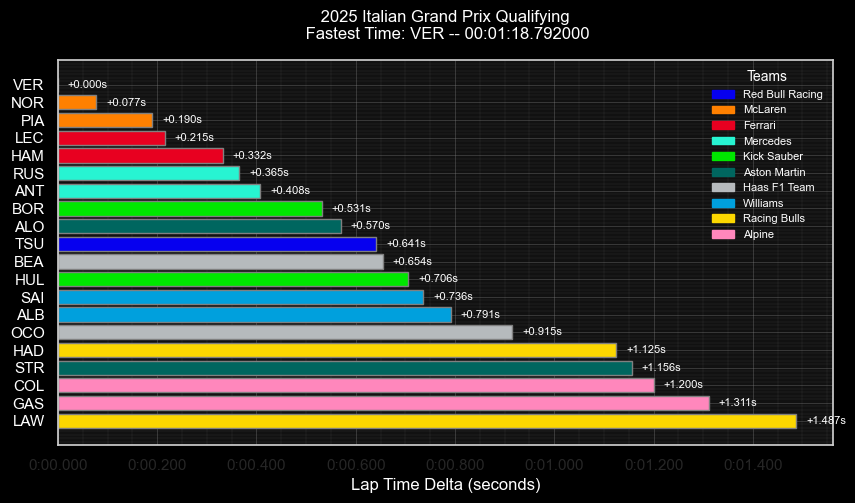

In [131]:
fig0, ax = plt.subplots(figsize=(10, 5), facecolor='black')
ax.set_facecolor('#111111')

ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'], color='White')

ax.set_title(f" {session.event['EventDate'].year} {session.event['EventName']} {session.name} \n Fastest Time: {pole_lap.Driver} -- {str(fastest_laps['LapTime'].iloc[0]).split()[-1]}", #split is used to remove the '0 days part..'
             color='white', 
             pad=15)
ax.set_xlabel("Lap Time Delta (seconds)", color='white')

# To add seconds on the side of each drivers time for more readibility
for i, delta in enumerate(fastest_laps['LapTimeDelta']):
    ax.text(delta + pd.Timedelta(seconds=0.02), #offsets the label so they dotn overlap
            i,
            f"+{delta.total_seconds():.3f}s",
            va='center',
            color='white',
            fontsize=8)

# iverts to show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.3, alpha=0.3)

# draw the lines in between major lines
ax.minorticks_on()

# Keep grid behind bars
ax.set_axisbelow(True)

# create one legend entry per team
unique_teams = fastest_laps['Team'].unique()
legend_patches = []

for team in unique_teams:
    color = fastf1.plotting.get_team_color(team,session=session)
    patch = mpatches.Patch(color=color, label=team)
    legend_patches.append(patch)

# add legend to plot
legend = ax.legend(handles=legend_patches,
          loc='upper right',
          frameon=False,
          labelcolor='white',
          title='Teams',
          fontsize=8,)

# Simply to set the legend title white and fontsize
legend.get_title().set_color('white') 
legend.get_title().set_fontsize(10)
plt.show()

What can we get from this?

    - Verstappen has the fastest time (also shown at the top of the graphic)
    - Every other drivers time is shown relative to verstappens, with the difference in seconds for accuracy on the side of the bar
    - Easily distinct teams by color (for example ferrari drivers are shown with 'red') also contains the legend for reference
    

Now let's get into the RACE

core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '44', '23', '5', '12', '6', '55', '87', '22', '30', '31', '10', '43', '18', '14', '27']


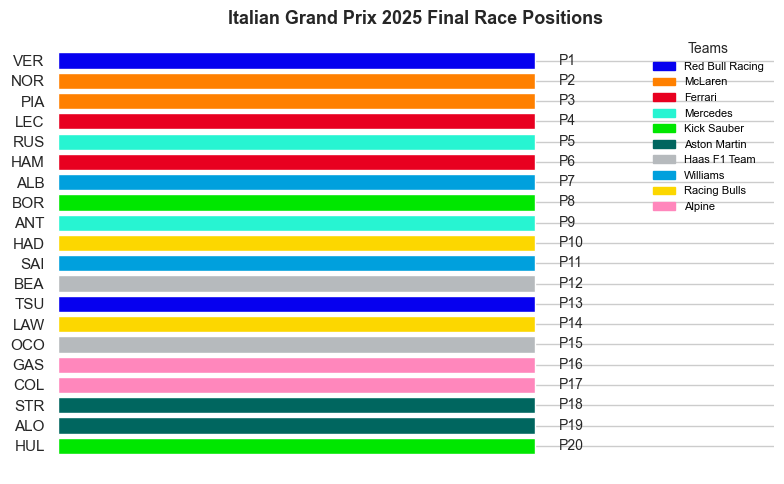

In [132]:
race_session = load_session(2025, "Monza", "R")

results = race_session.results.copy()

drivers = results['Abbreviation']
teams = results['TeamName']
positions = results['Position'].astype(int)

# get official team colors
colors = [fastf1.plotting.get_team_color(team, session=race_session) for team in teams]

fig1, ax = plt.subplots(figsize=(8, 5))

# horizontal bars, all bars same length since this servbes to only show the final position
ax.barh(drivers, [1]*len(drivers), color=colors)

# invert y axis so P1 is on top
ax.invert_yaxis()

# remove x axis and unnecessary ticks
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(0, 1.5)
ax.set_title(f"{race_session.event['EventName']} {race_session.event['EventDate'].year} Final Race Positions", fontsize=13, fontweight='bold')

# add position labels next to each driver
for i, pos in enumerate(positions):
    ax.text(1.05, i, f"P{pos}", va='center', fontsize=10)

# create one legend entry per team
unique_teams = fastest_laps['Team'].unique()
legend_patches = []

for team in unique_teams:
    color = fastf1.plotting.get_team_color(team,session=session)
    patch = mpatches.Patch(color=color, label=team)
    legend_patches.append(patch)

# add legend to plot
ax.legend(handles=legend_patches,
          loc='upper right',
          frameon=False,
          labelcolor='black',
          title='Teams',
          title_fontsize=10,
          fontsize=8)
# clean style
ax.set_frame_on(False)
plt.tight_layout()
plt.show()


In [133]:
# get the neccesary columns
laps = race_session.laps.pick_quicklaps() #Getting only the valid laps for each driver as they are the most relevant, (excluding ones like under security car or entering and exiting pits)

laps_data = laps[['Driver', 'LapTime', 'Compound', 'Stint']].copy()
laps_data['LapTime'] = laps_data['LapTime'].dt.total_seconds() # convert laptimes in seconds

Here I am assignin shapes for different tyre compounds so they can be passed as parameters for marker and plotted by matplotlib.scatter; HARD, MEDIUM, SOFT ->  'o', '+' , '^'

In [134]:
marker_map = {'HARD': 'o', 'MEDIUM': '+', 'SOFT': '^'} #just a dictionary with string as key value pairs
laps_data['TyreMarker'] = laps_data['Compound'].map(marker_map) #marks every occurence of compunds into the value pair specified on the dictionary above
print(laps_data)

    Driver  LapTime Compound  Stint TyreMarker
1      VER   84.859   MEDIUM    1.0          +
2      VER   83.512   MEDIUM    1.0          +
3      VER   83.262   MEDIUM    1.0          +
4      VER   83.588   MEDIUM    1.0          +
5      VER   83.576   MEDIUM    1.0          +
..     ...      ...      ...    ...        ...
966    ALO   84.224   MEDIUM    1.0          +
967    ALO   84.146   MEDIUM    1.0          +
968    ALO   84.185   MEDIUM    1.0          +
971    ALO   84.078     HARD    2.0          o
972    ALO   83.757     HARD    2.0          o

[912 rows x 5 columns]


Ploting the data

- the for loop below, loops 3 times which is the number of different compounds used in the tires
1. Selects the first compound and filters the laps_data to contain only that, then that subset gets plotted
2. and the same thing with the rest of the marker

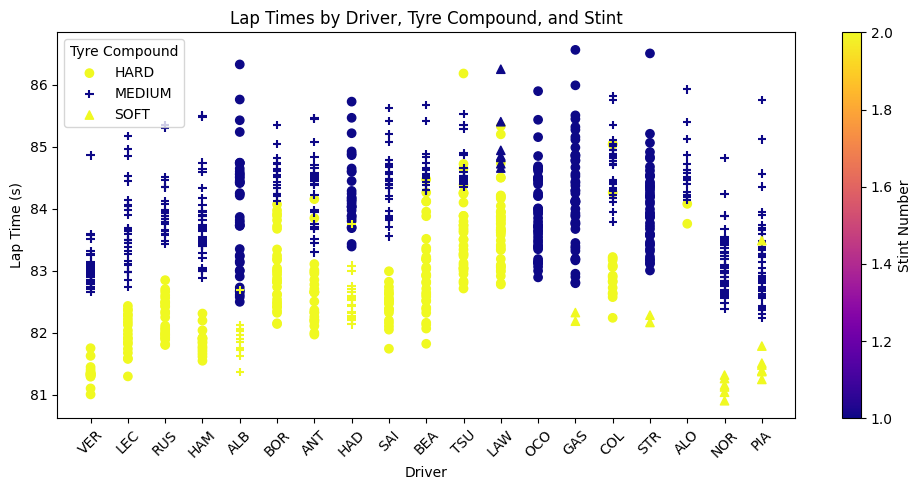

In [135]:
plt.style.use('default')
fig2, ax = plt.subplots(figsize=(10, 5))

for compound, marker in marker_map.items():
    subset = laps_data[laps_data['Compound'] == compound] # filter based on the current compound on the loop 
    sc = ax.scatter(
        subset['Driver'], 
        subset['LapTime'],
        c=subset['Stint'],  # color by stint number
        cmap='plasma',  
        marker=marker, # shape by tyre compound
        alpha=1,
        label=compound
    )

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Stint Number")

ax.set_xlabel("Driver")
ax.set_ylabel("Lap Time (s)")
ax.set_title("Lap Times by Driver, Tyre Compound, and Stint")

ax.legend(title="Tyre Compound")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



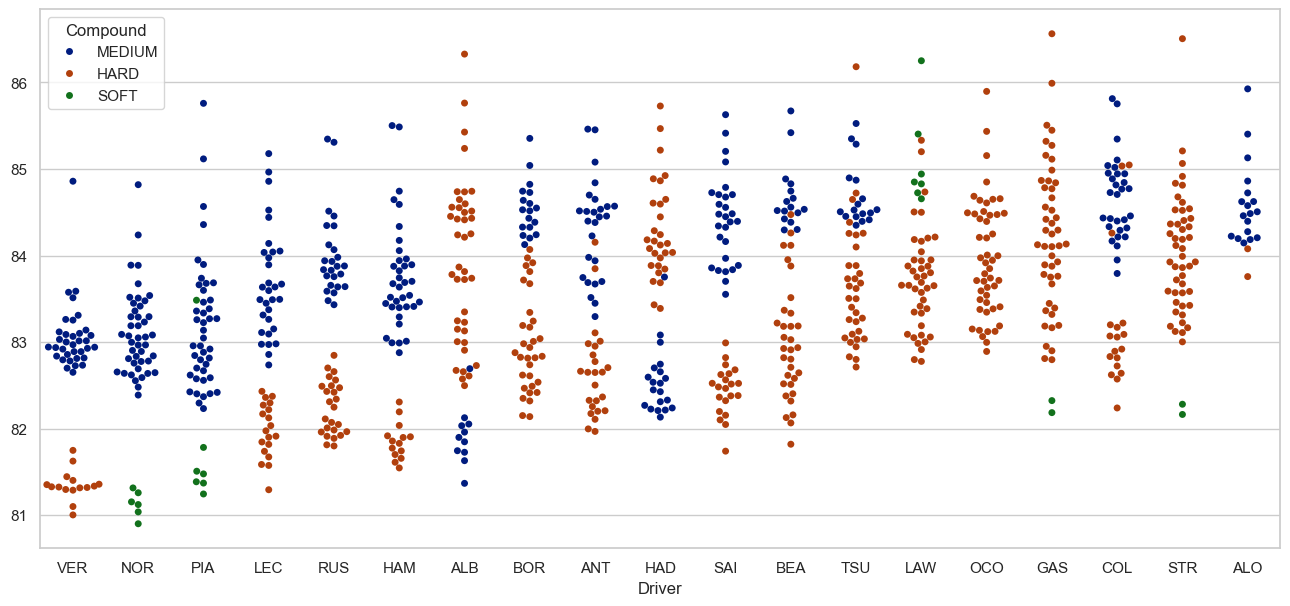

In [136]:
import seaborn as sns
plt.figure(figsize=(16, 7))
sns.set_theme(style="whitegrid", palette = "dark")


# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=laps_data, x= laps_data['Driver'], y= laps_data['LapTime'], hue= laps_data['Compound'])
ax.set(ylabel="")
plt.show()


C:\Users\Andis\AppData\Local\Temp\ipykernel_30356\1447012347.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


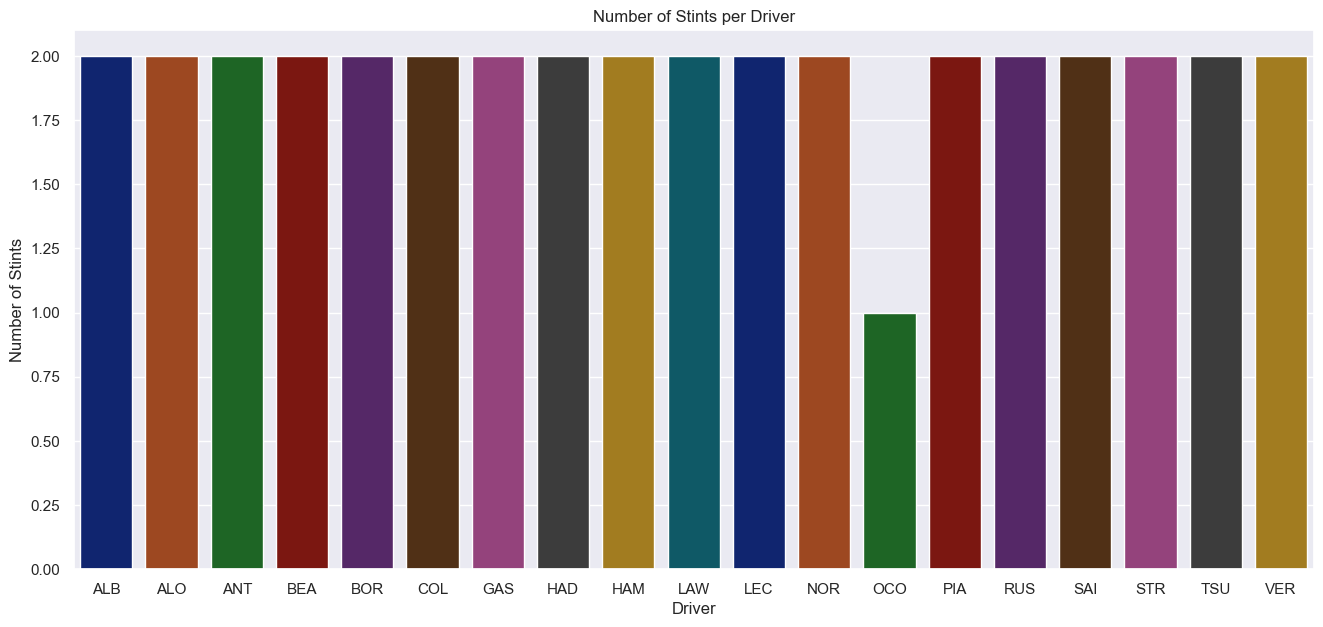

In [ ]:
# Counts the unique stints for each driver
stint_counts = laps_data.groupby('Driver')['Stint'].nunique().reset_index()

# Set the theme
sns.set_theme(style="darkgrid")

fig3, ax = plt.subplots(figsize=(16, 7))

sns.barplot(
    data=stint_counts,
    x='Driver',
    y='Stint',   
    ax=ax,
    palette="dark"
)

ax.set_title("Number of Stints per Driver")
ax.set_ylabel("Number of Stints")

plt.show()

At first, it may seem counterintuitive that most drivers set faster lap times on hard or medium tyres rather than on soft ones.
Logically, soft tyres should provide more grip, and they do in theory, but in real races, soft tyres are usually used during the opening laps when cars are heavier with fuel and running close together.
The dirty air generated in traffic reduces aerodynamic efficiency and therefore lap performance.

As the race progresses, cars spread out, begin using DRS more effectively, and, importantly, the track surface becomes more 'stickier'  and provides additional grip.
These factors combined can make lap times on harder tyres later in the race faster than those on soft tyres earlier on.

c:\Users\Andis\Desktop\F1PythonProject\Formula1Analysis\.venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
c:\Users\Andis\Desktop\F1PythonProject\Formula1Analysis\.venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


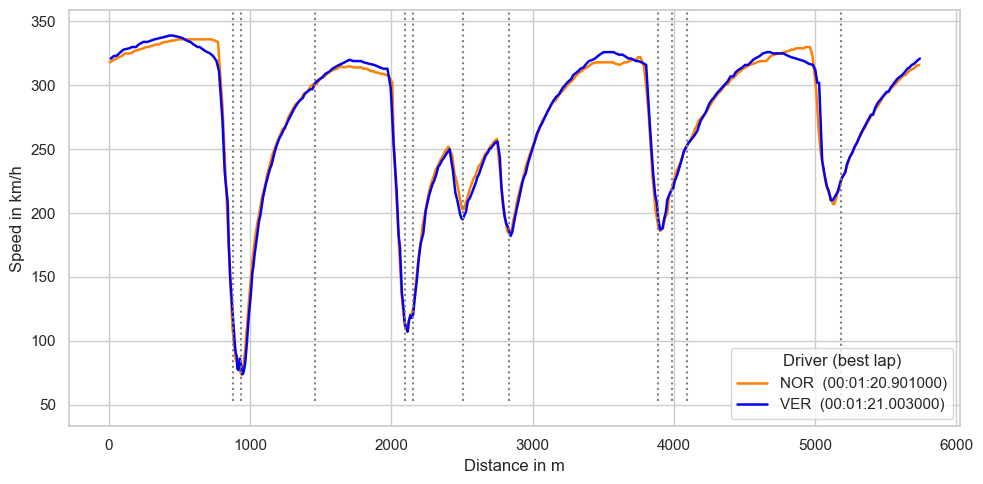

In [ ]:
laps_clean = race_session.laps[race_session.laps['LapTime'].notna()]

# gets only the data the 2 fastest driverss to later fetch their data 
top2 = (laps_clean.groupby('Driver')['LapTime']
                .min()
                .sort_values()
                .head(2))
drivers = list(top2.index)  

# prepare the dictionary for both drivers
driver_data = {}
vmins, vmaxs = [], [] #used for plot range of the minspeed and max speed

for drv in drivers:
    lap = race_session.laps.pick_driver(drv).pick_fastest()
    car = lap.get_car_data().add_distance() #get car data and the distance
    color = fastf1.plotting.get_team_color(lap['Team'], session=race_session) 
    label = f"{drv}  ({str(lap['LapTime']).split()[-1]})"
    driver_data[drv] = {'car': car, 'color': color, 'label': label}
    vmins.append(car['Speed'].min())
    vmaxs.append(car['Speed'].max())

# Corner info
circuit_info = race_session.get_circuit_info()

# plot
fig4, ax = plt.subplots(figsize=(10, 5))

# plot both lines
for drv, info in driver_data.items():
    car = info['car']
    ax.plot(car['Distance'], car['Speed'],
            color=info['color'], linewidth=1.8, label=info['label'])

# Vertical dotted lines for corners
v_min = min(vmins)
v_max = max(vmaxs)
ax.vlines(x=circuit_info.corners['Distance'],
          ymin=v_min-20, ymax=v_max+20,
          linestyles='dotted', colors='grey')


# Labels, legend, limits
ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')
ax.legend(title='Driver (best lap)')
ax.set_ylim([v_min - 40, v_max + 20])

plt.tight_layout()
plt.show()